In [1]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os
from scipy.integrate import solve_ivp
import time

from tqdm.auto import tqdm

In [2]:
dirname = '../src/model_ctypes/_bondarenko/'
filename_so = os.path.join(dirname, 'bondarenko.so')
filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.fun.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']

In [7]:
S = legend_states.copy()
C = legend_constants.copy()

In [4]:
def fun(t, y, params):
    ydot = np.zeros_like(y)
    model.fun(t, y, ydot, params)
    return ydot

# Generate synthetic  baselines

In [ ]:
CL_list = [1000, 500, 250]

for CL in tqdm(CL_list):

    C['CL'] = CL
    n_beats = 10
    stim_period = CL
    t_sampling = 1.

    t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
    t_span = 0, t_space[-1]
    
    sol = solve_ivp(fun, y0=S,
                t_span=t_span, t_eval=t_space,
                args=(C.values.copy(),),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling,
                )
    
    t, y = sol.t, sol.y
    v = y[1]
    
    v = v[-CL - 1: -CL - 1 + 250]
    
    folder_name = "../data/bondarenko/syn/"
    
    filename_phenotype = os.path.join(folder_name, f'phenotypes/phenotype_{CL}.csv')
    df = pd.DataFrame(v, columns=['V'])
    df.to_csv(filename_phenotype, index=False)
    
    filename_state = os.path.join(folder_name, f'states/state_{CL}.txt')
    np.savetxt(filename_state, y[:, -1])

In [5]:
CL = 1000

C['CL'] = CL
n_beats = 10
stim_period = CL
t_sampling = 1.

t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
t_span = 0, t_space[-1]

In [ ]:
%%time
sol = solve_ivp(fun, y0=S,
                t_span=t_span,# t_eval=t_space,
                args=(C.values.copy(),),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling,
                )

In [6]:
%%time
sol = solve_ivp(fun, y0=S,
                t_span=t_span, t_eval=t_space,
                args=(C.values.copy(),),
                method='LSODA',
                max_step=1. * t_sampling,
                )

CPU times: user 1min 7s, sys: 42.1 s, total: 1min 49s
Wall time: 35.6 s


In [7]:
t, y = sol.t, sol.y

In [8]:
output = pd.DataFrame(y.T, columns=legend_states.index)

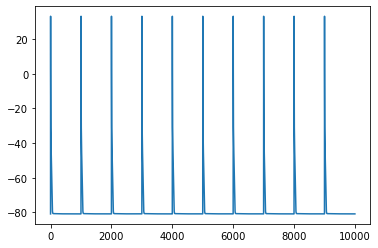

In [9]:
plt.plot(output['V'])

In [10]:
output.min().describe()

count    1.860000e+02
mean     3.084665e+03
std      1.645535e+04
min     -8.088310e+01
25%      7.418449e-09
50%      5.091690e-04
75%      3.602478e-01
max      1.418000e+05
dtype: float64

# tol

In [ ]:
atol_list = []
tol = 1e-6

for c in output:
    
    x = output[c]
    ptp = np.ptp(x)
    
    if ptp > 0.5:
        atol_list.append(tol)
        
    elif 0 < ptp <= 0.5:
        
        m = np.min(np.abs(x))
        
        if m > 0:
            atol_list.append(m / 10)
            
        else:
            atol_list.append(np.max(np.abs(x)) / 1e3)
            
    else:
        atol_list.append(42)
        
    continue
    if atol_list[-1] < 1e-9:
        atol_list[-1] = 1e-9